In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image 
import time 
from IPython import display

%matplotlib inline 

import utils as utils

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Residual Network Development & Testing 

Resisual networks feature skip-forward connections.  [This paper](https://web.stanford.edu/class/cs331b/2016/projects/zhao.pdf) features successful use of a autoencoder with skip-forward connections.  

In [122]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation 

def ResidualAutoencoderV2(batch_size=32): 
    """ returns a keras model"""
    
    input_shape = (64, 64, 1)
    img_input = Input(shape=input_shape, batch_size=batch_size)

    
    ## Downsampling  
    x = img_input
    x = Conv2D(filters=64, kernel_size=(4, 4), padding='same', kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_1 = x 
    x = Conv2D(filters=64, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_2 = x 
    x = Conv2D(filters=128, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 
    
    shortcut_3 = x     
    x = Conv2D(filters=256, kernel_size=(8, 8), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 

    shortcut_4 = x 
    x = Conv2D(filters=518, kernel_size=(4, 4), strides=(2, 2), padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation('relu')(x) 


    
    ## Upsampling 
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=(2, 2), padding='same')(x) 
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_4]) 
    x = Conv2DTranspose(filters=128, kernel_size=8, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_3]) 
    x = Conv2DTranspose(filters=64, kernel_size=16, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_2]) 
    x = Conv2DTranspose(filters=64, kernel_size=16, strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x) 

    x = Add()([x, shortcut_1])
    x = Conv2DTranspose(filters=1, kernel_size=64, padding='same')(x)    

    return tf.keras.Model(img_input, x, name='res_autoencoder_v2')
    

In [119]:
model = ResidualAutoencoderV2()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [117]:
test.shape

(32, 64, 64, 1)

In [121]:
model.fit(test, test, epochs=2)

Train on 32 samples
Epoch 1/2
32/32 [==============================] - 10s 324ms/sample - loss: 2204.5786 - accuracy: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 11s 351ms/sample - loss: 1.1948 - accuracy: 0.0000e+00


## Dataset preparation 

In [134]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

filenames = utils.get_filenames_list('data/dataset64-easy-snp/')
train_ds = utils.create_dataset(filenames, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

## Train 

In [136]:
model.fit(train_ds)

Train for 50 steps
50/50 [==============================] - 449s 9s/step - loss: 4.6433 - accuracy: 0.0404


AbortedError:  Operation received an exception:Status: 3, message: could not create a convolution backward data descriptor, in file tensorflow/core/kernels/mkl_conv_grad_input_ops.cc:494
	 [[node res_autoencoder_v2/conv2d_transpose_64/conv2d_transpose (defined at <ipython-input-136-7a875f4d503b>:1) ]] [Op:__inference_distributed_function_9509]

Function call stack:
distributed_function


# Testing 
Take and image, pass through network.

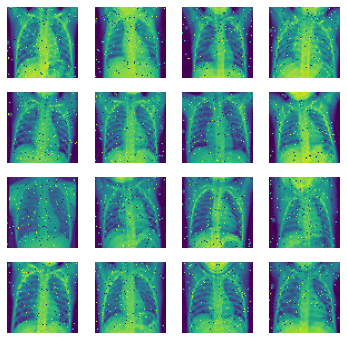

In [137]:
for i in train_ds.take(1): 
    ims = i[0]
    orgs = i[1]
    
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1) 

for i, ax in enumerate(ax): 
    ax.imshow(np.squeeze(ims[i]))
    ax.axis(False)

In [138]:
preds = model.predict(ims)

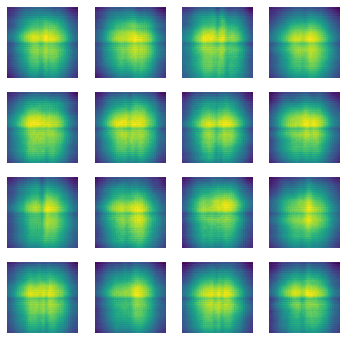

In [139]:
fig, ax = plt.subplots(4, 4, figsize=(6, 6))
ax = ax.reshape(-1)

for i, ax in enumerate(ax):
    ax.imshow(np.squeeze(preds[i]))
    ax.axis(False)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
i = 15

axes[0].imshow(np.squeeze(ims[i]))
axes[0].axis(False)
axes[0].set_title('Noisy')

axes[1].imshow(np.squeeze(x_logit[i]))
axes[1].axis(False)
axes[1].set_title('De-noised')

axes[2].imshow(np.squeeze(orgs[i]))
axes[2].axis(False)
axes[2].set_title('Original')
